##1.라이브러리 / 데이터 로드

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
from tqdm import tqdm

import datetime
from dateutil import relativedelta
from datetime import timedelta

In [13]:
df = pd.read_csv("/content/drive/MyDrive/funda/funda_train.csv")
df.shape

(6556613, 9)

## 2.데이터 형식 맞춰주기

In [14]:
df.store_id = df.store_id.astype(np.int16)
df.card_id = df.card_id.astype(np.int32)
df.card_company = df.card_company.astype('category')
df.installment_term = df.installment_term.astype(np.int8)
df.region = df.region.astype('category')
df.type_of_business = df.type_of_business.astype('category')

In [16]:
df['transaction_time'] = df['transacted_date'] + "-" + df['transacted_time']
df['transaction_time'] = pd.to_datetime(df['transaction_time'], format='%Y-%m-%d-%H:%M', infer_datetime_format=True)

In [19]:
df.drop(['transacted_date', 'transacted_time'], axis=1, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   store_id          int16         
 1   card_id           int32         
 2   card_company      category      
 3   installment_term  int8          
 4   region            category      
 5   type_of_business  category      
 6   amount            float64       
 7   transaction_time  datetime64[ns]
dtypes: category(3), datetime64[ns](1), float64(1), int16(1), int32(1), int8(1)
memory usage: 175.1 MB


##3.데이터 전처리

### 1) 결제 취소 건 삭제
코드 출처 : DACON 코드공유 https://dacon.io/competitions/official/140472/codeshare/1361?page=1&dtype=recent&ptype=pub

In [25]:
def cancel_delete(df_):
  df = df_.copy(deep=True) #깊은 복사는 내부에 객체들까지 모두 새롭게 copy 되는 것
  store_id_lst = df.store_id.unique()
  del_idx = []
  extra_idx = []
  for store_id in (store_id_lst):
    tmp = df[(df['store_id'] == store_id)]
    minus_amount = tmp[tmp['amount'] < 0]
    for idx, col in minus_amount.iterrows(): #index랑 열을 뽑아줌
      df_search = tmp[(tmp['amount'] == - col['amount']) & 
                      (tmp['card_id'] == col['card_id']) &
                      (tmp['card_company'] == col['card_company'])] #취소금액과 같은 금액 찾기
      if len(df_search) == 0:
        # 결제 취소했지만 데이터에 없는 경우 -> 추후 제거
        extra_idx.append(idx)
      else:
        # 가장 최근 결제 내역을 제거
        del_idx.append(df_search.index[-1])
        del_idx.append(idx)
        
  df.drop(del_idx, axis=0, inplace=True)
  df.drop(extra_idx, axis=0, inplace=True)
  return df

In [26]:
%%time
df_cleaned = cancel_delete(df)

CPU times: user 1min 48s, sys: 90 ms, total: 1min 48s
Wall time: 1min 48s


In [27]:
# 매출이 0으로 되어있는 데이터도 제거
%%time
df_cleaned.drop(df_cleaned[df_cleaned.amount == 0].index, axis=0, inplace=True)

CPU times: user 593 ms, sys: 2 ms, total: 595 ms
Wall time: 591 ms


In [28]:
df_cleaned.shape

(6417640, 8)

### 2) 최근 폐점한 경우
코드 출처 : DACON 코드공유 https://dacon.io/competitions/official/140472/codeshare/1361?page=1&dtype=recent&ptype=pub

In [29]:
df_prep = df_cleaned.set_index('transaction_time')
df_prep.head()

,store_id,card_id,card_company,installment_term,region,type_of_business,amount
transaction_time,,,,,,,
2016-06-01 13:13:00,0,0,b,0,NaN,기타 미용업,1857.142857
2016-06-01 18:12:00,0,1,h,0,NaN,기타 미용업,857.142857
2016-06-01 18:52:00,0,2,c,0,NaN,기타 미용업,2000.000000
2016-06-01 20:22:00,0,3,a,0,NaN,기타 미용업,7857.142857
2016-06-02 11:06:00,0,4,c,0,NaN,기타 미용업,2000.000000


In [44]:
# 최근 데이터가 없는 상점을 찾음.
def no_data(df, at_least_need_date = '2019-01-01'):
  u_store_id = df['store_id'].unique() # 0~2136번\
  del_store_id_lst = []
  for s_id in u_store_id:
    df_tmp = df[df['store_id'] == s_id]
    # 최근 매출 날짜를 봄
    df_tmp = df_tmp.resample('M').sum().index[-1]
    # 2019년 1월 1일 이전이면 예측 0으로. 이 부분은 나중에 바꿔도 됨.
    if df_tmp < dt.strptime(at_least_need_date, "%Y-%m-%d"):
      del_store_id_lst.append(s_id)
  return del_store_id_lst

In [45]:
%%time
no_data_store_id = no_data(df_prep)
no_data_store_id

CPU times: user 12.7 s, sys: 27.6 ms, total: 12.7 s
Wall time: 12.7 s


In [46]:
# 전부 2018년도까지만 매출 데이터 있음, 2019년도 매출 데이터가 없음 
print(no_data_store_id)

[111, 257, 374, 479, 619, 632, 640, 772, 802, 838, 999, 1217, 1233, 1520, 1527, 1567, 1598, 1604, 1685, 1967, 2027, 2053, 2086, 2119]


In [67]:
len(no_data_store_id)

24

### 3) 매출이 중간에 끊긴 경우(리모델링?) - 이전 매출 기록 삭제 필요 -36건
안창배 멘토님 코드 참고



150일 이상 폐점했던 기간이 있는 경우, 이전 매출과 비교했을 때 매출이 급증하는 양상을 보여준다. 

따라서 150일 이상 폐점한 경우, 폐점 이전 매출 데이터를 제거

In [47]:
df = df_cleaned

In [50]:
# 각 상점 별로 데이터가 존재하는 기간
store_period = (df.groupby('store_id').transaction_time.max() - df.groupby('store_id').transaction_time.min()).reset_index(name='period')
store_period.nsmallest(10, 'period')

,store_id,period
1950,2119,340 days 21:25:00
1887,2053,583 days 01:50:00
937,999,617 days 00:24:00
1189,1283,635 days 06:11:00
1370,1481,636 days 22:59:00
655,702,637 days 04:13:00
1434,1553,639 days 00:02:00
641,687,640 days 03:19:00
1796,1951,640 days 05:26:00
1404,1519,640 days 08:26:00


In [ ]:
# 2018년에 폐점한 것으로 보이는 케이스
df[df.store_id==1950]

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
5924203,1950,4211430,a,2016-08-12 16:41:00,0,NaN,NaN,14.285714
5924204,1950,4211430,a,2016-08-12 16:41:00,0,NaN,NaN,-14.285714
5924205,1950,4211430,a,2016-08-12 16:42:00,0,NaN,NaN,14.285714
5924206,1950,4211430,a,2016-08-12 16:43:00,0,NaN,NaN,-14.285714
5924207,1950,4211431,a,2016-08-16 08:39:00,0,NaN,NaN,857.142857
...,...,...,...,...,...,...,...,...
5927305,1950,4213194,c,2019-02-28 15:30:00,0,NaN,NaN,714.285714
5927306,1950,4213319,a,2019-02-28 17:01:00,0,NaN,NaN,571.428571
5927307,1950,4212770,b,2019-02-28 18:20:00,0,NaN,NaN,1714.285714
5927308,1950,4213320,c,2019-02-28 18:47:00,0,NaN,NaN,214.285714


In [ ]:
# 최근에 새로 생긴 상점인 케이스
df[df.store_id==2025]

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
6176740,2025,4388414,h,2017-05-26 20:01:00,0,NaN,NaN,2928.571429
6176741,2025,4388414,h,2017-05-26 20:02:00,0,NaN,NaN,714.285714
6176742,2025,4388415,a,2017-05-26 21:10:00,0,NaN,NaN,3285.714286
6176743,2025,4388416,g,2017-05-26 21:30:00,0,NaN,NaN,1857.142857
6176744,2025,4388417,a,2017-05-27 17:56:00,0,NaN,NaN,2428.571429
...,...,...,...,...,...,...,...,...
6181633,2025,4391795,a,2019-02-27 15:43:00,0,NaN,NaN,2285.714286
6181634,2025,4391669,a,2019-02-27 20:40:00,0,NaN,NaN,2428.571429
6181635,2025,4391796,b,2019-02-27 23:38:00,0,NaN,NaN,2857.142857
6181636,2025,4391136,a,2019-02-28 13:48:00,0,NaN,NaN,2428.571429


In [52]:
# 휴점기간 찾기

max_time_diff = lambda group: (group.store_id.values[0], group.transaction_time.diff().max()) #df.diff() : 열 간의 차이 반환

from tqdm import tqdm #tqdm 공부하기
from joblib import Parallel, delayed #joblib, multi-processing 공부하기
res = Parallel(n_jobs=14)(delayed(max_time_diff)(group) 
                         for _, group in tqdm(df.groupby('store_id'), total=df.store_id.nunique()))


100%|██████████| 1967/1967 [00:11<00:00, 167.27it/s]


In [53]:
max_diff_df = pd.DataFrame(res, columns=['store_id', 'max_diff'])
max_diff_df.nlargest(10, 'max_diff')

,store_id,max_diff
742,795,656 days 21:07:00
1117,1204,560 days 22:24:00
590,632,518 days 14:52:00
251,271,492 days 01:49:00
1912,2081,485 days 02:40:00
1563,1696,462 days 19:57:00
1691,1836,416 days 03:53:00
469,506,317 days 20:46:00
1643,1783,306 days 17:02:00
1260,1364,288 days 03:46:00


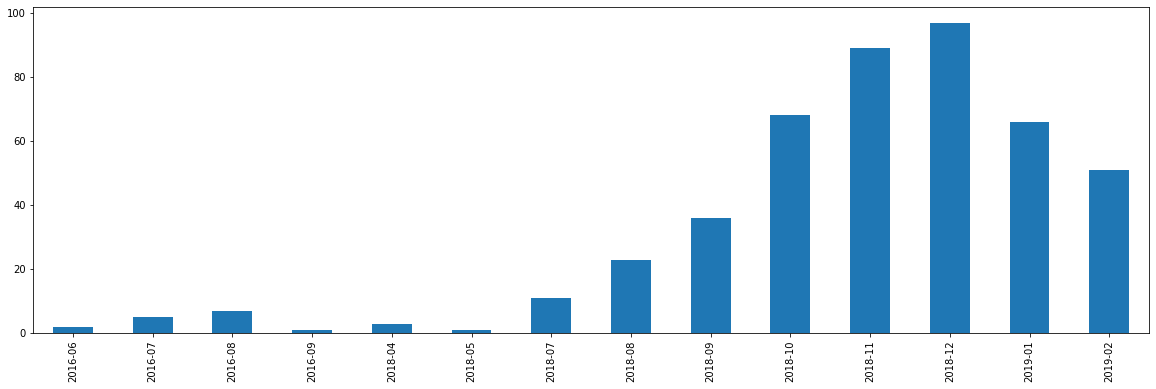

In [58]:
# 월별 매출 그래프로 그려보면 다시 열고 나서 매출이 대체적으로 급증함. 리모델링? 매장 확장? 이 데이터들의 경우 초기데이터가 학습에 활용되면 안될 것임
plt.figure(figsize=(20,6))
df[df.store_id == 1204].transaction_time.dt.to_period("M").value_counts().sort_index().plot.bar()

In [63]:
for days in (10, 50, 90, 150, 200, 300):
    print(f"{days}일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: {(max_diff_df.max_diff>timedelta(days=days)).sum()}")

10일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 962
50일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 160
90일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 86
150일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 37
200일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 24
300일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 9


In [64]:
max_diff_df[max_diff_df.max_diff > timedelta(days = 150)].nsmallest(10, 'max_diff')

,store_id,max_diff
578,619,151 days 00:23:00
1058,1139,159 days 00:06:00
1090,1176,159 days 22:40:00
1522,1650,161 days 22:28:00
1630,1770,168 days 05:49:00
414,447,169 days 22:45:00
1355,1466,174 days 01:46:00
1830,1989,175 days 17:52:00
1325,1435,176 days 17:22:00
720,772,180 days 21:45:00


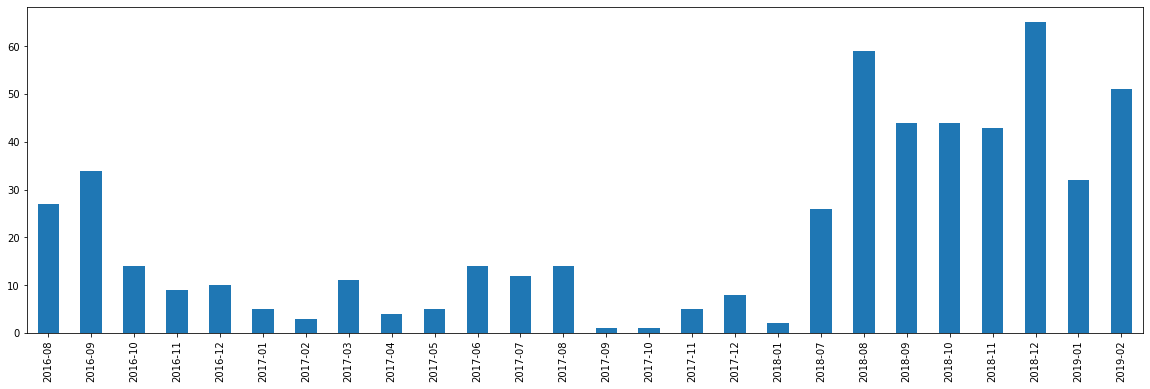

In [ ]:
# 하나하나 store_id 넣어보며 살펴 봄
plt.figure(figsize=(20,6))
df[df.store_id==1435].transacted_date.dt.to_period("M").value_counts().sort_index().plot.bar()

# 150일 이상 폐점했던 기간이 있는 경우, 이전 매출과 비교했을 때 매출이 급증하는 양상을 보여준다.

In [65]:
remodeling_store_id = max_diff_df[max_diff_df.max_diff > timedelta(days = 150)].store_id.tolist()
remodeling_store_id

[69,
 237,
 257,
 271,
 279,
 447,
 506,
 515,
 588,
 619,
 632,
 706,
 772,
 795,
 1041,
 1139,
 1176,
 1204,
 1299,
 1364,
 1373,
 1379,
 1435,
 1466,
 1598,
 1650,
 1692,
 1696,
 1770,
 1783,
 1836,
 1928,
 1989,
 2023,
 2058,
 2081,
 2094]

In [66]:
len(remodeling_store_id)

37

###4) feature 전처리 - type_of_business / region

In [68]:
business_store_count = df.groupby('type_of_business').store_id.nunique()
business_store_count

type_of_business
가구 소매업                3
가전제품 소매업              3
가정용 세탁업               5
가정용 직물제품 소매업          2
간이음식 포장 판매 전문점       18
                     ..
한의원                   1
화장품 및 화장용품 도매업        7
화장품, 비누 및 방향제 소매업    16
화초 및 식물 소매업           8
화훼류 및 식물 도매업          1
Name: store_id, Length: 145, dtype: int64

In [69]:
# 10개 이하의 스토어를 가지는 business type은 다 ETC로
df.type_of_business = df.type_of_business.astype('object')
df.loc[df.type_of_business.isin(business_store_count[business_store_count<=10].index), 'type_of_business'] = 'ETC'
df.type_of_business = df.type_of_business.astype('category')

In [70]:
region_count = df.groupby('region').store_id.nunique()
region_count.sort_values(axis=0, ascending=False)[:20]

region
경기 수원시     34
충북 청주시     32
경남 창원시     29
경기 성남시     24
경기 평택시     23
경남 김해시     23
제주 제주시     22
서울 강남구     22
경기 부천시     21
충남 천안시     21
경기 화성시     21
서울 마포구     21
대전 서구      20
경기 용인시     20
전북 전주시     20
경북 포항시     19
경기 남양주시    16
울산 남구      16
경북 경주시     16
서울 송파구     16
Name: store_id, dtype: int64

In [71]:
# 지역은 다 도로 변환
df.region = df.region.str[:2]
df.region = df.region.astype('category')

In [72]:
region_count = df.groupby('region').store_id.nunique()
region_count.sort_values(axis=0, ascending=False)

region
경기    303
서울    189
부산    101
경남     95
경북     71
인천     64
대구     63
충북     60
충남     57
강원     44
전북     42
광주     41
전남     39
울산     37
대전     36
제주     31
세종      4
Name: store_id, dtype: int64

In [73]:
# type_of_business 결측치 채우기 ('ETC'로 채움)
df.type_of_business = df.type_of_business.astype('object')
df.type_of_business = df.type_of_business.fillna('ETC')
df.type_of_business = df.type_of_business.astype('category')

In [74]:
# region 결측치 채우기 ('ETC'로 채움)
df.region = df.region.astype('object')
df.region = df.region.fillna('ETC')
df.region = df.region.astype('category')

In [75]:
# 결측치 확인용
df.isnull().sum()

store_id            0
card_id             0
card_company        0
installment_term    0
region              0
type_of_business    0
amount              0
transaction_time    0
dtype: int64

##4.학습, 예측 데이터셋 만들기
안창배 멘토님 코드 

In [82]:
def train_test_splitter(df):
    '''
    주어진 데이터 중 마지막 3개월을 y로 둔다
    20%를 test로 분리
    '''
    y_bool = df.transaction_time >= datetime.datetime(2018, 12, 1)
    y = df[y_bool].groupby('store_id').amount.sum()
    X = df[~y_bool]
    
    train_index = y.sample(frac=0.8, random_state=85).index

    train_X = X[X.store_id.isin(train_index)]
    test_X = X[~X.store_id.isin(train_index)]

    train_y = y[y.index.isin(train_index)]
    test_y = y[~y.index.isin(train_index)]
    
    return train_X, test_X, train_y, test_y

In [83]:
train_X, test_X, train_y, test_y = train_test_splitter(df)

In [84]:
print(train_X.shape, train_y.shape)

(4584100, 8) (1560,)


In [85]:
print(test_X.shape, test_y.shape)

(1270937, 8) (390,)


##5.feature engineering 

In [88]:
def feature_extractor_each(store_id, group):
    # 평균 거래량
    mean_log_count = group.groupby('card_id').size().mean()
    
    # 최근 4개월간의 판매량
    recent_four_month = group.loc[group.transaction_time >= (datetime.datetime(2018, 12, 1) - relativedelta.relativedelta(months=4)), 'amount'].sum() * (3 / 4)

    # 최근 1개월간의 판매량
    recent_one_month = group.loc[group.transaction_time >= (datetime.datetime(2018, 12, 1) - relativedelta.relativedelta(months=1)), 'amount'].sum() * (3 / 1)

    # 최근 1년간의 판매량
    recent_one_year = group.loc[group.transaction_time >= (datetime.datetime(2018, 12, 1) - relativedelta.relativedelta(months=12)), 'amount'].sum() * (3 / 12)

    # 가장 거래가 많은 시간
    most_hour = group.transaction_time.dt.hour.value_counts().nlargest(1).index[0]

    # 가장 많은 지역, 가장 많은 type_of_business 해봤는데 중요하지 않은 피처로 판단되어 제거하였음

    return [store_id, 
            mean_log_count, recent_four_month, recent_one_month,
            recent_one_year, most_hour]

In [97]:
def feature_extractor(df):
  res = []
  for store_id, group in tqdm(df.groupby('store_id')):
      res.append(feature_extracto_eachr(store_id, group))

  feature_df = pd.DataFrame(res, columns=['store_id',
                      'mean_log_count', 'recent_four_month', 'recent_one_month',
                      'recent_one_year', 'most_hour'])
  return feature_df

In [98]:
%%time
feature_train_X = feature_extractor(train_X)
feature_test_X = feature_extractor(test_X)



  0%|          | 0/1560 [00:00<?, ?it/s]

  0%|          | 1/1560 [00:00<06:05,  4.26it/s]

  2%|▏         | 28/1560 [00:00<04:13,  6.05it/s]

  4%|▎         | 55/1560 [00:00<02:55,  8.55it/s]

  5%|▌         | 81/1560 [00:00<02:02, 12.05it/s]

  7%|▋         | 108/1560 [00:00<01:26, 16.88it/s]

  9%|▊         | 136/1560 [00:00<01:00, 23.50it/s]

 10%|█         | 163/1560 [00:00<00:43, 32.35it/s]

 12%|█▏        | 190/1560 [00:00<00:31, 43.95it/s]

 14%|█▍        | 218/1560 [00:01<00:22, 58.77it/s]

 16%|█▌        | 247/1560 [00:01<00:17, 77.05it/s]

 18%|█▊        | 274/1560 [00:01<00:13, 97.68it/s]

 19%|█▉        | 302/1560 [00:01<00:10, 121.17it/s]

 21%|██        | 329/1560 [00:01<00:08, 144.98it/s]

 23%|██▎       | 356/1560 [00:01<00:07, 167.19it/s]

 25%|██▍       | 383/1560 [00:01<00:06, 188.71it/s]

 26%|██▋       | 411/1560 [00:01<00:05, 207.79it/s]

 28%|██▊       | 438/1560 [00:01<00:05, 221.45it/s]

 30%|██▉       | 465/1560 [00:01<00:04, 228.67it/s]

 32%|███▏      | 4

CPU times: user 7.91 s, sys: 57.2 ms, total: 7.97 s
Wall time: 7.99 s


In [100]:
feature_train_X

,store_id,mean_log_count,recent_four_month,recent_one_month,recent_one_year,most_hour
0,0,2.434886,2.060036e+06,2.028000e+06,2.131714e+06,18
1,1,2.486172,2.486250e+05,2.408571e+05,2.781964e+05,14
2,2,1.422535,1.225500e+06,5.562857e+05,1.118750e+06,16
3,4,1.173714,2.444143e+06,2.649000e+06,2.539857e+06,19
4,5,1.489167,1.039586e+06,1.149900e+06,1.203882e+06,19
...,...,...,...,...,...,...
1555,2132,2.565915,2.122714e+06,2.189571e+06,2.291607e+06,12
1556,2133,1.888415,8.523214e+05,2.541429e+05,1.171211e+06,16
1557,2134,1.803063,1.090183e+05,1.823571e+05,4.724287e+05,12
1558,2135,1.373433,1.886893e+06,1.768286e+06,1.672304e+06,22


In [101]:
# X와 y사이의 store가 아귀가 맞는지 (train)
s1 = set(feature_train_X.store_id)
s2 = set(train_y.index)
assert len(s1) == len(s2) == len(s1&s2)

In [102]:
# X와 y사이의 store가 아귀가 맞는지 (test)
s1 = set(feature_test_X.store_id)
s2 = set(test_y.index)
if not len(s1) == len(s2) == len(s1&s2):
    inter_set = s1&s2
    feature_test_X = feature_test_X[feature_test_X.store_id.isin(inter_set)]
    test_y = test_y[test_y.index.isin(inter_set)]

##6.머신러닝 알고리즘 가져오기


In [103]:
# 안창배 멘토님 코드
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
clf = RandomForestRegressor(random_state=85)
clf.fit(feature_train_X, train_y)

train_pred_y = clf.predict(feature_train_X)
print(f"train MAE: {np.mean(abs(train_y - train_pred_y)):.4f}")

test_pred_y = clf.predict(feature_test_X)
print(f"test MAE: {np.mean(abs(test_y - test_pred_y)):.4f}")

train MAE: 315898.9631
test MAE: 733748.6894


RadomizedSearchCV 구현

In [104]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

estimators = [
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42)
]
estimators

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best'),
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False),
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
            

In [105]:
results = []
for estimator in estimators:
    result = []
    result.append(estimator.__class__.__name__)
    results.append(result)

pd.DataFrame(results)

,0
0,DecisionTreeRegressor
1,RandomForestRegressor
2,GradientBoostingRegressor


In [106]:
def make_params():

    max_depth = np.random.randint(10, 30, 1000)
    max_features = np.random.uniform(0.5, 1.0, 1000)

    param_distributions = {"max_depth": max_depth, "max_features": max_features }

    return param_distributions

param_distributions = make_params()
param_distributions

{'max_depth': array([27, 24, 28, 23, 27, 19, 28, 10, 12, 21, 29, 12, 21, 12, 22, 25, 13,
        11, 24, 28, 29, 10, 21, 12, 22, 10, 25, 12, 10, 28, 23, 29, 17, 21,
        14, 22, 11, 20, 19, 13, 19, 12, 10, 20, 11, 21, 29, 21, 12, 18, 10,
        28, 13, 20, 17, 16, 17, 14, 17, 27, 21, 10, 16, 25, 25, 21, 16, 21,
        11, 15, 28, 13, 24, 17, 11, 17, 12, 25, 25, 10, 11, 18, 25, 27, 12,
        13, 24, 25, 29, 15, 25, 19, 10, 28, 27, 13, 24, 27, 26, 27, 28, 13,
        20, 15, 20, 21, 10, 14, 28, 10, 15, 18, 10, 25, 13, 13, 16, 29, 25,
        19, 21, 23, 24, 20, 19, 14, 21, 13, 28, 11, 27, 28, 29, 23, 27, 19,
        18, 25, 12, 29, 19, 10, 21, 24, 11, 17, 28, 12, 22, 20, 26, 25, 16,
        20, 18, 12, 24, 12, 17, 15, 12, 16, 18, 24, 22, 22, 21, 22, 22, 20,
        16, 25, 14, 14, 21, 17, 23, 29, 10, 26, 24, 14, 17, 26, 21, 25, 14,
        15, 18, 16, 24, 22, 24, 21, 29, 22, 26, 13, 28, 25, 28, 22, 20, 22,
        22, 19, 23, 26, 14, 18, 21, 23, 11, 10, 21, 22, 18, 12, 16, 25, 27,

In [107]:
from sklearn.model_selection import RandomizedSearchCV

results = []
for estimator in estimators:
    result = []

    param_distributions = make_params()

    regressor = RandomizedSearchCV(estimator,
        param_distributions,
        n_iter=1000,
        scoring=None,
        n_jobs=-1,
        cv=3,
        verbose=2, 
        random_state=42)

    regressor.fit(feature_train_X, train_y)
    
    result.append(estimator.__class__.__name__)
    result.append(regressor.best_params_)
    result.append(regressor.best_estimator_)
    result.append(regressor.best_score_)
    result.append(regressor.cv_results_)
    results.append(result)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 13.6min finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 16.6min finished


In [108]:
df_cv = pd.DataFrame(results)
df_cv.columns = ["model", "params", "estimator", "score", "cv_result"]
df_cv = df_cv.sort_values("score", ascending=False)
df_cv

,model,params,estimator,score,cv_result
1,RandomForestRegressor,"{'max_features': 0.8207323544678131, 'max_dept...","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.745927,"{'mean_fit_time': [0.4653143088022868, 0.60422..."
2,GradientBoostingRegressor,"{'max_features': 0.662667183463378, 'max_depth...","([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.733069,"{'mean_fit_time': [0.40938909848531085, 0.5901..."
0,DecisionTreeRegressor,"{'max_features': 0.7427104477178823, 'max_dept...","DecisionTreeRegressor(ccp_alpha=0.0, criterion...",0.654100,"{'mean_fit_time': [0.007643858591715495, 0.008..."


In [110]:
best_estimator = df_cv.iloc[0]["estimator"]
best_estimator

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=0.8207323544678131,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

##7.학습(훈련)

In [111]:
best_estimator.fit(feature_train_X, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=0.8207323544678131,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [114]:
# train set와 valid set를 나눠 cross validation으로 train set으로 학습한 모델을 검증합니다.
# test 점수를 예측하기 전에 
from sklearn.model_selection import cross_val_predict

y_valid_predict = cross_val_predict(best_estimator, feature_train_X, train_y, cv=5, verbose=2, n_jobs=-1)
y_valid_predict[:5]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


array([1972258.54732196,  336763.99755154,  782520.00208907,
       2338322.71487199,  968948.90606965])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


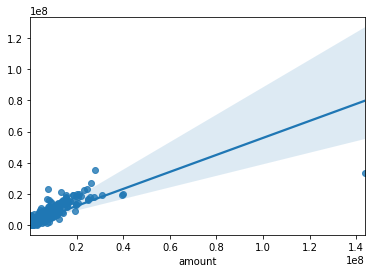

In [115]:
# regplot 으로 결과 값을 비교합니다.
# 회귀선에서 멀리 떨어질 수록 실제값과 예측값의 차이가 많이 납니다.
# 회귀선에 가까울수록 실제값과 예측값의 차이가 작습니다.

sns.regplot(train_y, y_valid_predict)

In [116]:
# r2_score 를 구합니다. 1에 가까울 수록 정확도가 높습니다.
# 0.75 이상의 값이 나오는지 확인합니다.

from sklearn.metrics import r2_score

r2_score(train_y, y_valid_predict)

0.6264556367202996

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


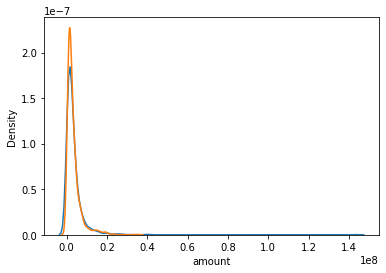

In [118]:
# distplot으로 정답값과 예측값의 분포를 그립니다.

sns.distplot(train_y, hist=False, label="train")
sns.distplot(y_valid_predict, hist=False, label="predict")

##8.예측

In [134]:
feature_X = feature_extractor(df[df.transaction_time >= datetime.datetime(2016,9,1)])



  0%|          | 0/1967 [00:00<?, ?it/s]

  0%|          | 1/1967 [00:00<10:37,  3.08it/s]

  1%|▏         | 26/1967 [00:00<07:23,  4.38it/s]

  3%|▎         | 51/1967 [00:00<05:08,  6.21it/s]

  4%|▍         | 77/1967 [00:00<03:35,  8.78it/s]

  5%|▌         | 103/1967 [00:00<02:30, 12.36it/s]

  7%|▋         | 130/1967 [00:00<01:46, 17.31it/s]

  8%|▊         | 157/1967 [00:00<01:15, 24.05it/s]

  9%|▉         | 183/1967 [00:01<00:54, 33.00it/s]

 11%|█         | 210/1967 [00:01<00:39, 44.76it/s]

 12%|█▏        | 236/1967 [00:01<00:29, 59.55it/s]

 13%|█▎        | 263/1967 [00:01<00:21, 77.65it/s]

 15%|█▍        | 290/1967 [00:01<00:17, 98.35it/s]

 16%|█▌        | 318/1967 [00:01<00:13, 121.66it/s]

 18%|█▊        | 345/1967 [00:01<00:11, 144.55it/s]

 19%|█▉        | 372/1967 [00:01<00:09, 165.05it/s]

 20%|██        | 399/1967 [00:01<00:08, 185.60it/s]

 22%|██▏       | 425/1967 [00:01<00:07, 202.36it/s]

 23%|██▎       | 451/1967 [00:02<00:07, 213.55it/s]

 24%|██▍       | 47

In [135]:
# 위에서 찾은 best_estimator 를 통해 실제값을 예측합니다.
pred = best_estimator.predict(feature_X)
pred[:5]

array([5873520.47389526,  849767.62639608, 1987114.60665739,
       7062569.62477384, 2092826.01070962])

In [141]:
prediction = pd.DataFrame({'store_id':feature_X.store_id, 'amount':pred})

##9. feature importance

In [121]:
feature_importance = best_estimator.feature_importances_

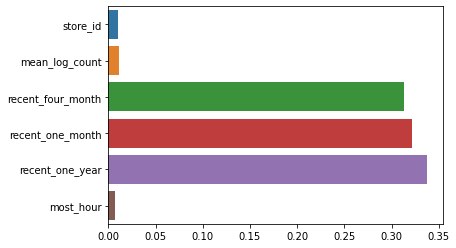

In [138]:
# 피처의 중요도 시각화 하기
sns.barplot(x=feature_importance, y=feature_X.columns)

#9.제출

In [ ]:
# 아직 구현 못함
# 3-(3) 리모델링 -> 최근 3개월치 단순 평균 값을 최종예측값으로
remodeling_store_id

In [ ]:
# 아직 구현 못함
# 3-(2) 폐점 -> 최종예측값을 0으로
no_data_store_id

In [142]:
# prediction은 store_id와 amount 두 개 칼럼으로 이루어진 df
submit = pd.read_csv("/content/drive/MyDrive/funda/submission.csv")
submit = submit[['store_id']].merge(prediction, on='store_id', how='left')
submit.amount = submit.amount.fillna(0)

In [143]:
submit.to_csv('/content/drive/MyDrive/201224.csv', index=False)